In [90]:
from SimPEG import *
from simpegem1d import EM1D, EM1DSurveyTD, Utils1D, get_vertical_discretization_time, set_mesh_1d
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import empymod

In [77]:
from simpegem1d import skytem_HM_2015
wave = skytem_HM_2015()

time = np.logspace(-5, -2, 21)
hz = get_vertical_discretization_time(time, facter_tmax=0.5, factor_tmin=10.)
mesh1D = set_mesh_1d(hz)
depth = -mesh1D.gridN[:-1]
LocSigZ = -mesh1D.gridCC

wave_type = "skytem"
if wave_type == "stepoff":
    TDsurvey = EM1DSurveyTD(
        rx_location = np.array([0., 0., 100.+30.]),
        src_location = np.array([0., 0., 100.+30.]),
        topo = np.r_[0., 0., 100.],
        depth = depth,
        rx_type = 'dBzdt',
        wave_type = 'stepoff',
        src_type = 'CircularLoop',
        a = 13.,
        I = 1.,
        time = time
    )
elif wave_type == "skytem":
    time_input_currents = wave.current_times[-7:]
    input_currents = wave.currents[-7:]

    TDsurvey = EM1DSurveyTD(
        rx_location = np.array([0., 0., 100.+30.]),
        src_location = np.array([0., 0., 100.+30.]),
        topo = np.r_[0., 0., 100.],
        depth = depth,
        rx_type = 'dBzdt',
        wave_type = 'general',
        src_type = 'CircularLoop',
        a = 13.,
        I = 1.,
        time = time,
        time_input_currents=time_input_currents,
        input_currents=input_currents,
        n_pulse = 2,
        base_frequency = 25.            
    )

sig_half = 1e-2
sig_blk = 5e-1
chi_half = 0.
expmap = Maps.ExpMap(mesh1D)

630.78313050504
-5.0 -1.4660200179590979 36


In [78]:
sig  = np.ones(TDsurvey.n_layer)*sig_half
blk_ind = (-30>LocSigZ) & (-50<LocSigZ)
sig[blk_ind] = sig_blk
m_true = np.log(sig)

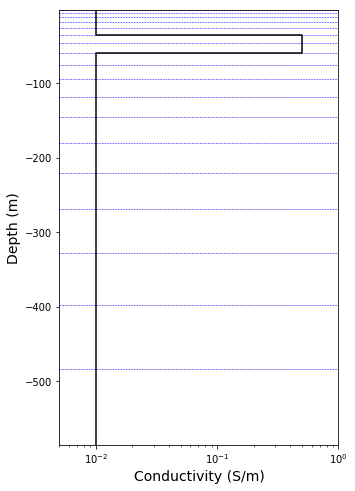

In [79]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(sig, LocSigZ, showlayers=True)

In [80]:
%%time
prob = EM1D(mesh1D, sigmaMap=expmap, jacSwitch=False)
if prob.ispaired:
    prob.unpair()
if TDsurvey.ispaired:
    TDsurvey.unpair()
prob.pair(TDsurvey)
prob.chi = np.zeros(TDsurvey.n_layer)
d_true = TDsurvey.dpred(m_true)

CPU times: user 255 ms, sys: 3.05 ms, total: 258 ms
Wall time: 261 ms


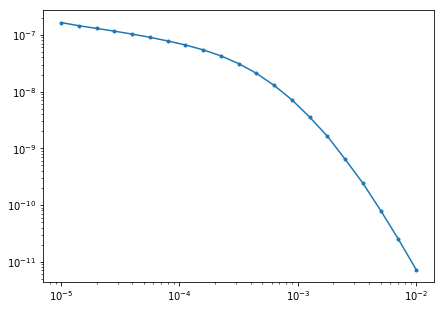

In [81]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(TDsurvey.time, -d_true, '.-')
axes.set_xscale('log');
axes.set_yscale('log');

In [82]:
np.random.seed(1)
TDsurvey.dtrue = d_true
std = 0.01
noise = std*abs(TDsurvey.dtrue)*np.random.randn(*TDsurvey.dtrue.shape)
floor = 0.
std = 0.15
TDsurvey.dobs = TDsurvey.dtrue+noise
uncert = abs(TDsurvey.dobs)*std+floor
prob.jacSwitch = True

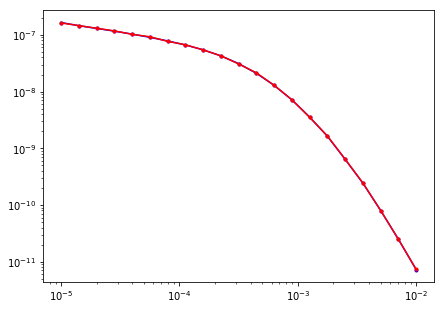

In [83]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(TDsurvey.time, -d_true, 'b.-')
axes.plot(TDsurvey.time, -TDsurvey.dobs, 'r.-')
axes.set_xscale('log');
axes.set_yscale('log');

In [84]:
dmisfit = DataMisfit.l2_DataMisfit(TDsurvey)
dmisfit.W = 1./(abs(TDsurvey.dobs)*std+floor)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||


In [85]:
m0 = np.log(np.ones_like(sig)*1e-2)
reg = Regularization.Simple(
    mesh1D
)
opt = Optimization.InexactGaussNewton(maxIter = 10, maxIterCG=5)
opt.maxIterLS = 5
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=2., coolingRate=1)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e0)
target = Directives.TargetMisfit()
inv = Inversion.BaseInversion(invProb, directiveList=[beta, betaest, target])
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')

In [86]:
%%time
mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  5.99e+00  3.13e+02  0.00e+00  3.13e+02    2.65e+01      0              
   1  3.00e+00  2.60e+02  2.40e+00  2.67e+02    2.32e+01      0              
   2  1.50e+00  9.60e+01  1.73e+01  1.22e+02    6.19e+01      0              
   3  7.49e-01  2.41e+01  2.33e+01  4.16e+01    2.03e+01      1              
   4  3.75e-01  1.60e+01  2.47e+01  2.52e+01    7.66e+01      1              
   5  1.87e-01  1.19e+01  2.56e+01  1.67e+01    1.07e+02      0              
------------------------- STOP! -------------------------
1 : |fc-

In [87]:
opt.counter.summary()
xc = opt.recall('xc')

Counters:
  InexactGaussNewton.doEndIteration       :        6
  InexactGaussNewton.doStartIteration     :        6
  InexactGaussNewton.scaleSearchDirection :        6

Times:                                        mean      sum
  EM1D.Jtvec_approx                       : 3.71e-04, 5.56e-03,   15x
  EM1D.Jvec_approx                        : 2.49e-02, 3.74e-01,   15x
  InexactGaussNewton.findSearchDirection  : 5.57e-03, 3.34e-02,    6x
  InexactGaussNewton.minimize             : 1.40e+01, 1.40e+01,    1x
  InexactGaussNewton.modifySearchDirection: 1.92e+00, 1.15e+01,    6x
  InexactGaussNewton.projection           : 7.77e-05, 2.25e-03,   29x


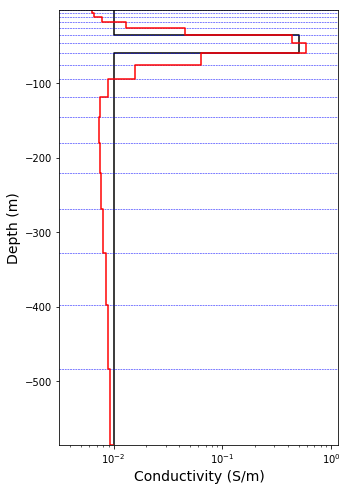

In [88]:
fig, ax = subplots(1,1, figsize=(5, 8))
Utils1D.plotLayer(sig, LocSigZ)
Utils1D.plotLayer(expmap*mopt, LocSigZ, showlayers=True, **{'color':'r'})

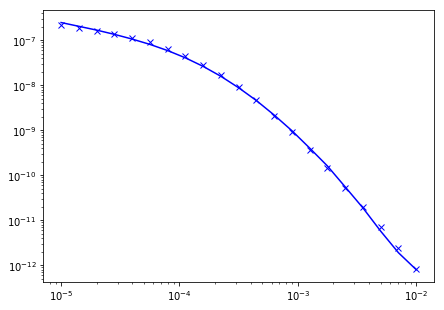

In [72]:
fig, axes = subplots(1,1, figsize = (7,5))
axes.plot(TDsurvey.time, -invProb.dpred, 'b-')
axes.plot(TDsurvey.time, -TDsurvey.dobs, 'bx')
axes.set_xscale('log');
axes.set_yscale('log');

In [31]:
# %%time
# dpredall = []
# maxIter = len(xc)
# prob.jacSwitch = False
# for i in range(maxIter):
#     dpredtemp = TDsurvey.dpred(xc[i])
#     dpredall.append(dpredtemp)

In [56]:
# from JSAnimation import IPython_display
# from matplotlib import animation

# fig, ax = subplots(1,2, figsize=(14, 8))
# ax[0].plot(sig, LocSigZ,  'b.-', lw=2)
# ax[0].grid(color='k', alpha=0.5, linestyle='dashed', linewidth=0.5)
# ax[1].grid(color='k', alpha=0.5, linestyle='dashed', linewidth=0.5)

# ax[1].plot(TDsurvey.time, -(TDsurvey.dobs), 'r.-', lw=2)
# ax[0].set_xscale('log')
# ax[1].set_xscale('log')
# ax[1].set_yscale('log')
# ax[0].set_xlim(1e-6, 1e-2)


# frame1, = ax[0].plot([], [],  'r.-', lw=2)
# frame2, = ax[1].plot([], [],  'b.-' , lw=2)

# def animate(i_id):
    
#     frame1.set_data(expmap*xc[i_id], LocSigZ)
#     frame2.set_data(TDsurvey.time, -(dpredall[i_id]))
    
#     ax[0].legend(('True', 'Pred'), loc=1, fontsize = 14)
#     ax[1].legend(('True', 'Pred'), loc=1, fontsize = 14)
    
#     ax[0].set_title('$\sigma$ model, Iter = ' + str(i_id+1), fontsize = 16)
#     ax[1].set_title('Pred and Obs data, Iter = ' + str(i_id+1), fontsize = 16)
#     return frame1, frame2

# animation.FuncAnimation(fig, animate, frames=maxIter, interval=40, blit=True)